In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv
/kaggle/input/godaddy-gru-98/GRU_f8_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f13_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f11_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f3_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f16_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f1_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f15_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f10_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f17_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f18_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f14_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f7_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f5_v98.h5
/kaggle/input/godaddy-gru-98/GRU_f4_v98.h5
/kaggle/input/godaddy-gru-98/GRU

In [2]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

VER = 98

# SET TO NONE TO TRAIN NEW MODEL
INFER_FROM_PATH = '/kaggle/input/godaddy-gru-98/'

In [3]:
# ORIGINAL TRAIN DATA
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
print('Original train data shape:', train.shape )

# EXTRA TRAIN DATA
df = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/revealed_test.csv')
print('Extra train data shape:', df.shape )

# CONCATENATE TRAIN DATA
train = pd.concat([train,df],axis=0,ignore_index=True)
train.first_day_of_month = pd.to_datetime(train.first_day_of_month)
train = train.sort_values(['cfips','first_day_of_month'])
train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['year'] = train.first_day_of_month.dt.year
print('Concatenated train data shape',train.shape)
train.head()

Original train data shape: (122265, 7)
Extra train data shape: (6270, 7)
Concatenated train data shape (128535, 9)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pop,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,41527.0,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,41527.0,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,41527.0,2019
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,41527.0,2019
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,41527.0,2019


In [4]:
# FIRST DAY, LAST DAY
train.first_day_of_month.min(), train.first_day_of_month.max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

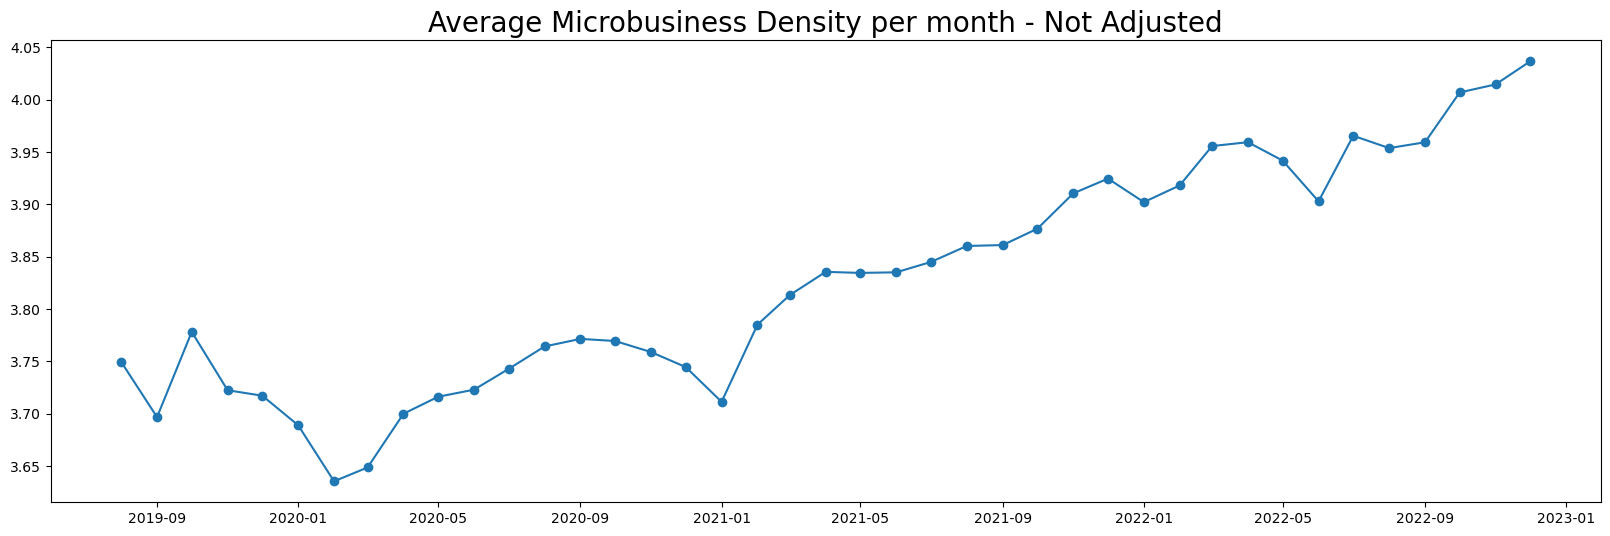

In [5]:
# PLOT AVERAGE MD PER MONTH
tmp = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp.index, tmp,'-o')
plt.title('Average Microbusiness Density per month - Not Adjusted',size=20)
plt.show()

In [6]:
adults = {}
COLS = ['GEO_ID','NAME','S0101_C01_026E']

for k in [2017,2018,2019,2020,2021]:
    df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
    df2021 = df2021.iloc[1:]
    df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
    df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adults[k] = df2021.set_index('cfips').S0101_C01_026E.to_dict()
    
train['adult2021'] = train.cfips.map(adults[2021])
for k in [2019,2020,2021,2022]:
    train['adults'] = train.cfips.map(adults[k-2])
    train.loc[train.year==k,'microbusiness_density'] *=\
         train.adults / train.adult2021

/tmp/ipykernel_32/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_32/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_32/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_32/1436298718.py:5: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv(f'/kaggle/input/census-data-for-godaddy/ACSST5Y{k}.S0101-Data.csv',usecols=COLS)
/tmp/ipykernel_32/1436298718.py:5: D

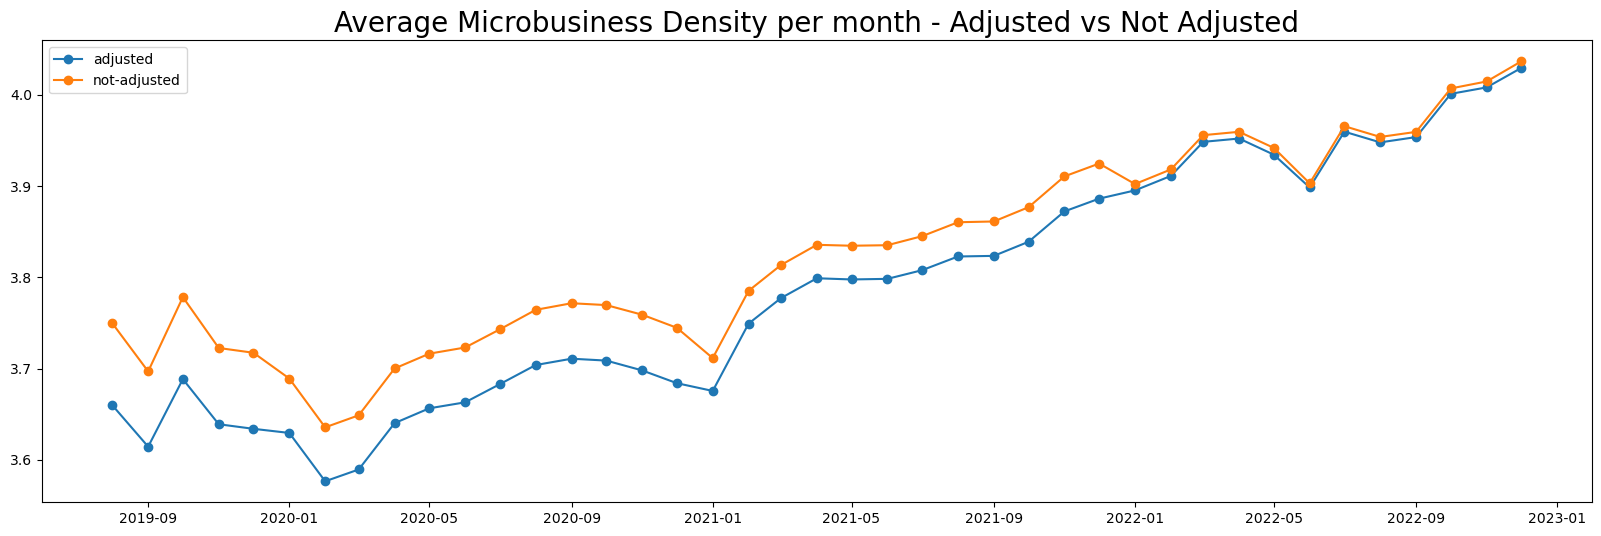

In [7]:
# PLOT AVERAGE MD PER MONTH
tmp2 = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp2.index, tmp2,'-o', label='adjusted')
plt.plot(tmp.index, tmp,'-o', label='not-adjusted')
plt.title('Average Microbusiness Density per month - Adjusted vs Not Adjusted',size=20)
plt.legend()
plt.show()

In [8]:
QUANT = 0.1
THRESH = 50

train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['m'] = train.groupby('cfips').microbusiness_density.transform('max')

c = train.adult2021.quantile(q=QUANT)
KEEP = train.loc[(train.adult2021>=c)&(train.m<THRESH),'cfips'].unique()
print('We will train with', len(KEEP),'large counties')

We will train with 2814 large counties


In [9]:
SMALL = train.cfips.nunique() - len(KEEP)
print('There are ',SMALL,'small counties')

There are  321 small counties


In [10]:
TOTAL_MONTHS = 41
WIDTH = 35

data2 = train.loc[~train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((SMALL, TOTAL_MONTHS))[:,-1*WIDTH:]
print('Small county data has shape',data2.shape)

Small county data has shape (321, 35)


In [11]:
COPIES = 18

y_data2 = np.zeros((321*COPIES,3))
x_data2 = np.zeros((321*COPIES,1))
for j in range(321):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data2[i,] = data2[j,k+(WIDTH-COPIES-5)] # LAST MONTH OF 13 MONTH TRAIN
        y_data2[i,] = data2[j,k+(WIDTH-COPIES-2):k+(WIDTH-COPIES+1)] # LAST 3 MONTHS OF 5 MONTH PREDICT
x_data2.shape, y_data2.shape

((5778, 1), (5778, 3))

In [12]:
data = train.loc[train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((len(KEEP), TOTAL_MONTHS))[:,-1*WIDTH:]
print('Large county data has shape',data.shape)

Large county data has shape (2814, 35)


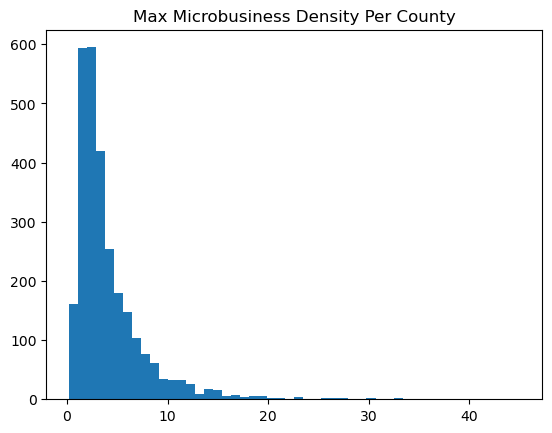

In [13]:
plt.hist( np.max(data,axis=1),bins=50 )
plt.title('Max Microbusiness Density Per County')
plt.show()

In [14]:
x_data = np.zeros((len(KEEP)*COPIES, WIDTH-COPIES-4)) # X_TRAIN TIME SERIES ARE 13 MONTHS
y_data = np.zeros((len(KEEP)*COPIES, 5)) # Y_TRAIN TIME SERIES ARE 5 MONTHS
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

In [15]:
for j in range(len(KEEP)):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data[i,] = data[j,k:k+(WIDTH-COPIES-4)]
        y_data[i,] = data[j,k+(WIDTH-COPIES-4):k+(WIDTH-COPIES+1)]

In [16]:
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

In [17]:
x_data3 = x_data.copy()
y_data3 = y_data.copy()

In [18]:
# CONVERT TO RATIOS
for k in range(WIDTH-COPIES-5):
    x_data3[:,k+1] = x_data[:,k+1] / x_data[:,k]

In [19]:
# CONVERT TO RATIOS
y_data3[:,0] = y_data[:,0] / x_data[:,-1]
for k in range(4):
    y_data3[:,k+1] = y_data[:,k+1] / y_data[:,k]

In [20]:
x_data3 = x_data3[:,1:]

In [21]:
# STANDARIZE
mn = np.mean(x_data3)
sd = np.std(x_data3)
x_data3 = (x_data3 - mn)/sd
y_data3 = (y_data3 - mn)/sd
print('Average ratio =',mn,'and Average std =', sd)

Average ratio = 1.002049802661262 and Average std = 0.049110348928488375


In [22]:
FEATURES = [f'f{x}' for x in range(WIDTH-COPIES-4-1)]
TARGETS = [f'y{x}' for x in range(5)]
train_data = pd.DataFrame(x_data3,columns=FEATURES)
train_data[TARGETS] = y_data3
train_data['cfips'] = np.repeat(KEEP,COPIES)
print('Our GRU training data has shape:', train_data.shape )
train_data.head()

Our GRU training data has shape: (50652, 18)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,y0,y1,y2,y3,y4,cfips
0,0.125577,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,1001
1,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,1001
2,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,1001
3,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,1001
4,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,1001


In [23]:
FEATURES, TARGETS


(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'],
 ['y0', 'y1', 'y2', 'y3', 'y4'])

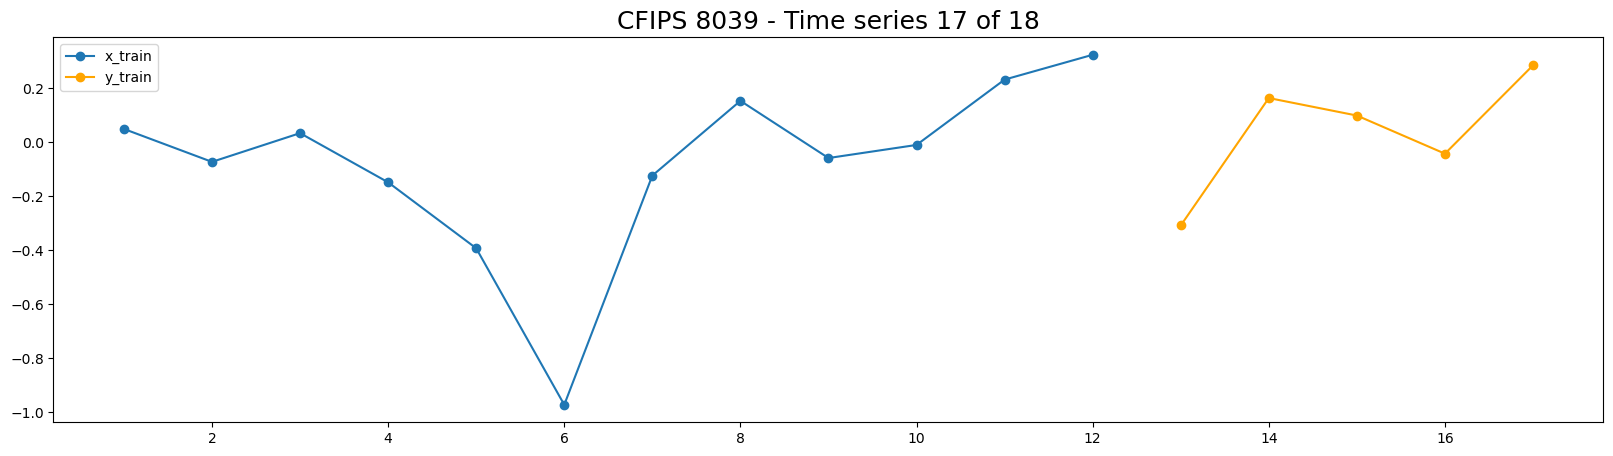

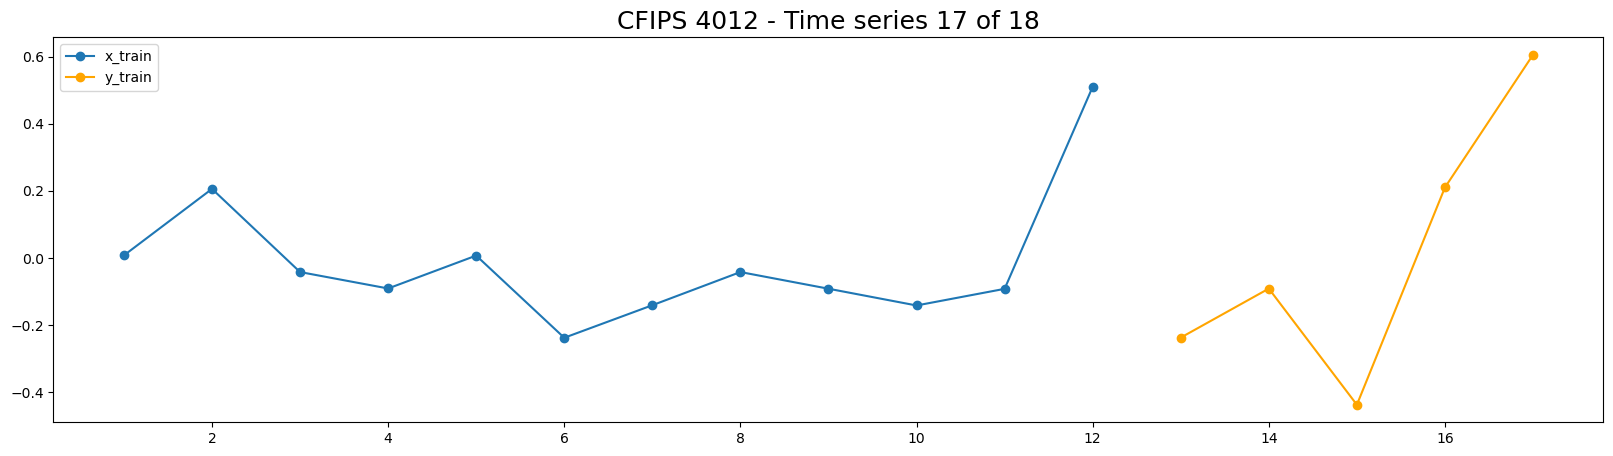

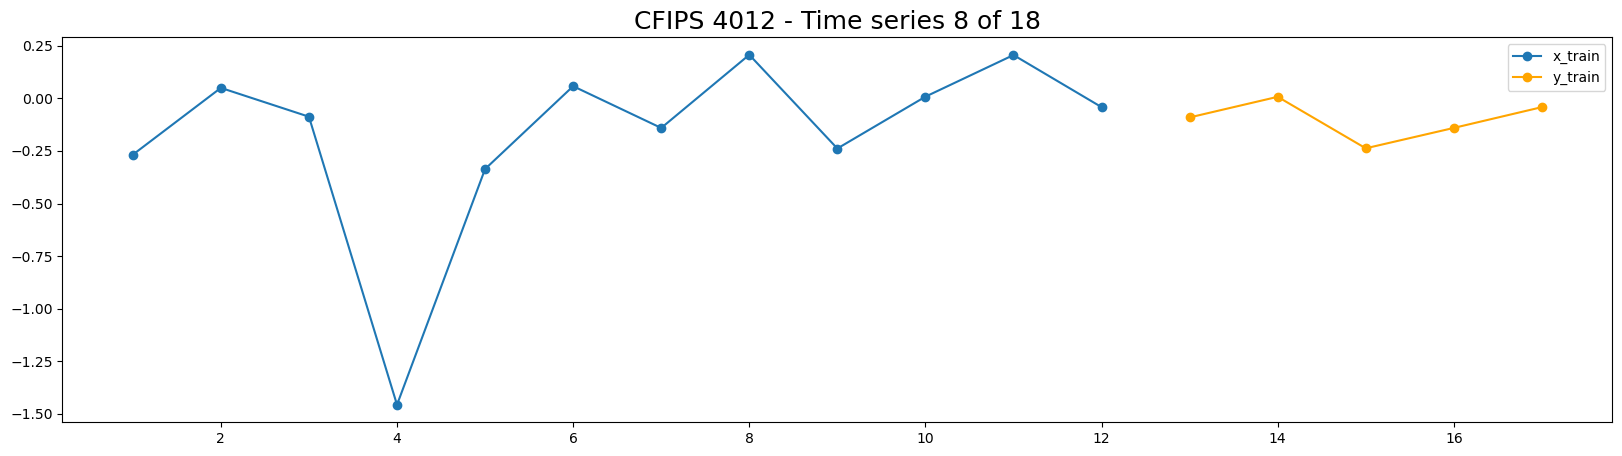

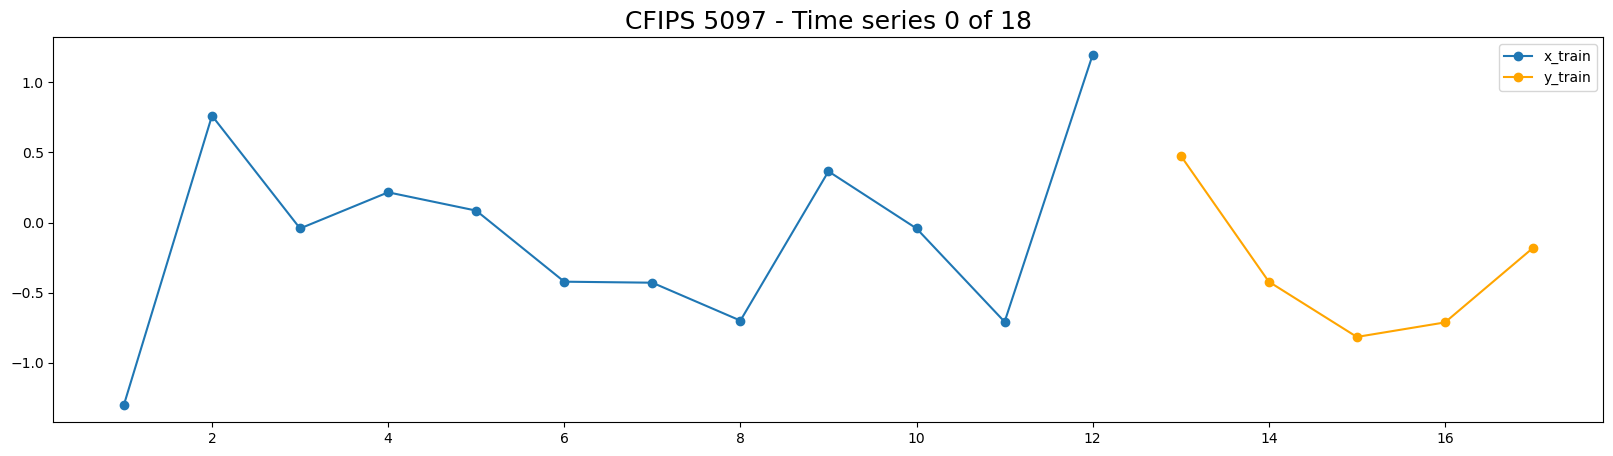

In [24]:
for k in range(4):
    j = np.random.choice(np.arange(len(x_data2)))
    
    row = j//COPIES
    col = j%COPIES
    
    plt.figure(figsize=(20,5))
    x = np.arange(WIDTH-COPIES-4-1)+1
    plt.plot(x,x_data3[j,],'-o',label='x_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES],y_data3[j,],
             '-o',color='orange',label='y_train')   
    plt.title(f'CFIPS {KEEP[row]} - Time series {col} of {COPIES}',size=18)
    plt.legend()
    plt.show()

In [25]:
import tensorflow as tf
from sklearn.model_selection import GroupKFold
print('Tensorflow version',tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow version 2.12.0


In [26]:
def build_model():
    
    inp = tf.keras.Input(shape=(WIDTH-COPIES-4-1,1)) # INPUT SHAPE IS 12
    
    x = tf.keras.layers.GRU(units=8, return_sequences=True)(inp)
    x = tf.keras.layers.GRU(units=8, return_sequences=True)(x)
    x = tf.keras.layers.GRU(units=8, return_sequences=False)(x)
    x = tf.keras.layers.Dense(5,activation='linear')(x) # OUTPUT SHAPE IS 5
    model = tf.keras.Model(inputs=inp, outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [27]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 gru (GRU)                   (None, 12, 8)             264       
                                                                 
 gru_1 (GRU)                 (None, 12, 8)             432       
                                                                 
 gru_2 (GRU)                 (None, 8)                 432       
                                                                 
 dense (Dense)               (None, 5)                 45        
                                                                 
Total params: 1,173
Trainable params: 1,173
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time

FOLDS = 20
VERBOSE = 2
oof = np.zeros((len(train_data),5))
!mkdir models

skf = GroupKFold(n_splits=FOLDS)
skf = skf.split(train_data, train_data['y0'], train_data['cfips'])
for fold,(train_idx, valid_idx) in enumerate(skf):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    X_train = train_data.loc[train_idx, FEATURES]
    y_train = train_data.loc[train_idx, TARGETS]
    X_valid = train_data.loc[valid_idx, FEATURES]
    y_valid = train_data.loc[valid_idx, TARGETS]
    
    # WEIGHT RECENT SAMPLE MORE
    GRP = len(train_idx)//COPIES
    w = np.array( [1] * (COPIES-7) + [1,1,2,2] + [2,2,2] )
    w = w/np.sum(w)
    
    model = build_model()
    if INFER_FROM_PATH is None:
        h = model.fit(X_train,y_train, 
                      validation_data = (X_valid,y_valid),
                      sample_weight = np.tile(w,GRP),
                      batch_size=4, epochs=2, verbose=VERBOSE)
    else:
        model.load_weights(INFER_FROM_PATH + f'GRU_f{fold}_v{VER}.h5')
    model.save_weights(f'models/GRU_f{fold}_v{VER}.h5')
    
    oof[valid_idx,] = model.predict(X_valid, verbose=VERBOSE)

#########################
### Fold 1
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 23ms/step
#########################
### Fold 2
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 20ms/step
#########################
### Fold 3
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 19ms/step
#########################
### Fold 4
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 20ms/step
#########################
### Fold 5
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 20ms/step
#########################
### Fold 6
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 21ms/step
#########################
### Fold 7
### Train size 48114 Valid size 2538
#########################
80/80 - 2s - 2s/epoch - 19ms/step
#########################
### Fold 8
### Train size 48114 Vali

In [29]:
def smape(y_true, y_pred):
    
    # CONVERT TO NUMPY
    y_true = np.array(y_true.flatten())
    y_pred = np.array(y_pred.flatten())
    
    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1
    
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [30]:
oof.shape, train_data.shape


((50652, 5), (50652, 18))

In [31]:
# UNDO STANDARDIZATION
oof2 = oof.copy()
oof2 = (oof2*sd)+mn

In [32]:
# AVERAGE PREDICTED RATIO FOR 5 FUTURE MONTHS
for k in range(5):
    print(oof2[:,k].mean(),f' is average predicted future month {k+1} divided by future month {k}')

1.0031450462258666  is average predicted future month 1 divided by future month 0
1.0027551500723553  is average predicted future month 2 divided by future month 1
1.0031979863684872  is average predicted future month 3 divided by future month 2
1.0032563737034434  is average predicted future month 4 divided by future month 3
1.0032098475379698  is average predicted future month 5 divided by future month 4


In [33]:
# CONVERT RATIOS INTO MICROBUSINESS DENSITY
oof5 = oof2.copy()
oof5[:,0] = x_data[:,-1] * oof5[:,0]
for k in range(4):
    oof5[:,k+1] = oof5[:,k] * oof5[:,k+1]

In [34]:
# CV SCORE FOR TOP 90% LARGE COUNTIES
y2 = y_data.copy()
m = smape(y2[:,-3:],oof5[:,-3:])
print('CV SMAPE of large counties =',m)

CV SMAPE of large counties = 2.719115201594347


In [35]:
# MERGE LAST VALUE PREDICTIONS FOR SMALL COUNTIES
oof3 = np.concatenate([x_data2,x_data2,x_data2],axis=1)
y3 = np.concatenate([y2[:,-3:],y_data2],axis=0)
oof4 = np.concatenate([oof5[:,-3:],oof3],axis=0)
m = smape(y3,oof4)
print('We will predict last value for small counties')
print('CV SMAPE of all counties =',m)
print('Note: PP below improves CV by 0.05')

We will predict last value for small counties
CV SMAPE of all counties = 3.054472428240278
Note: PP below improves CV by 0.05


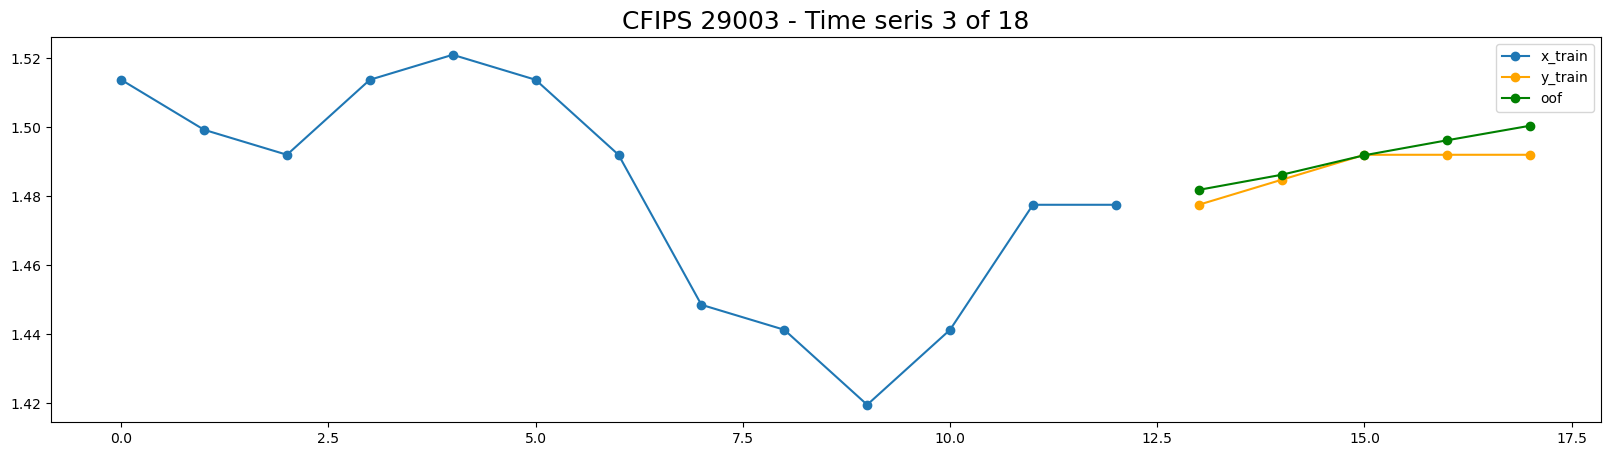

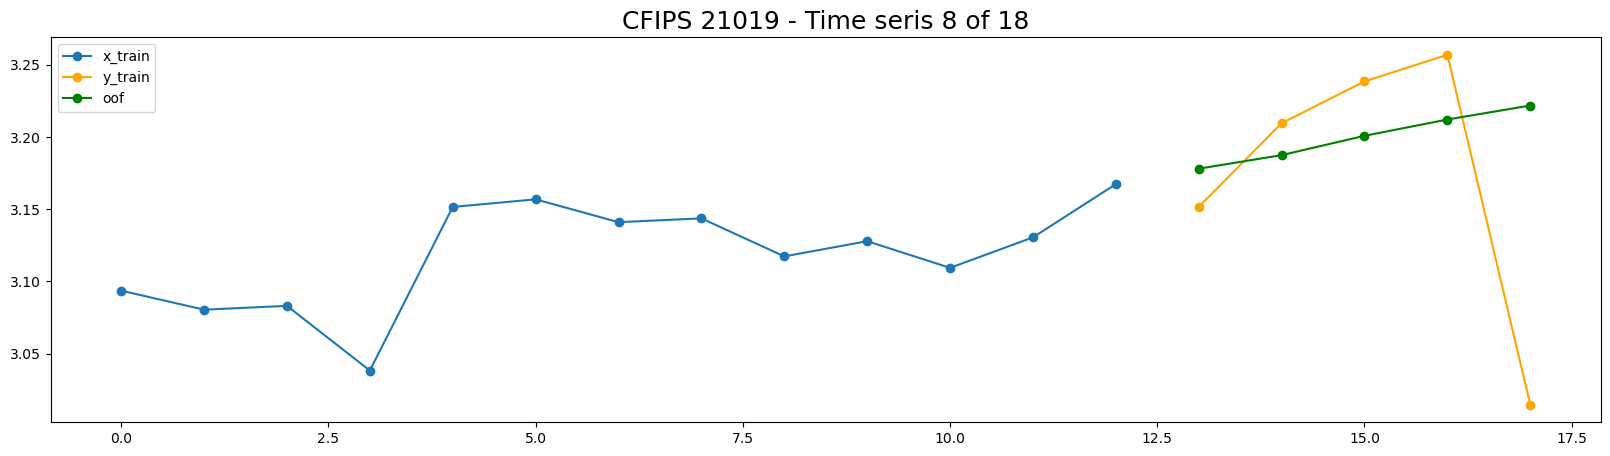

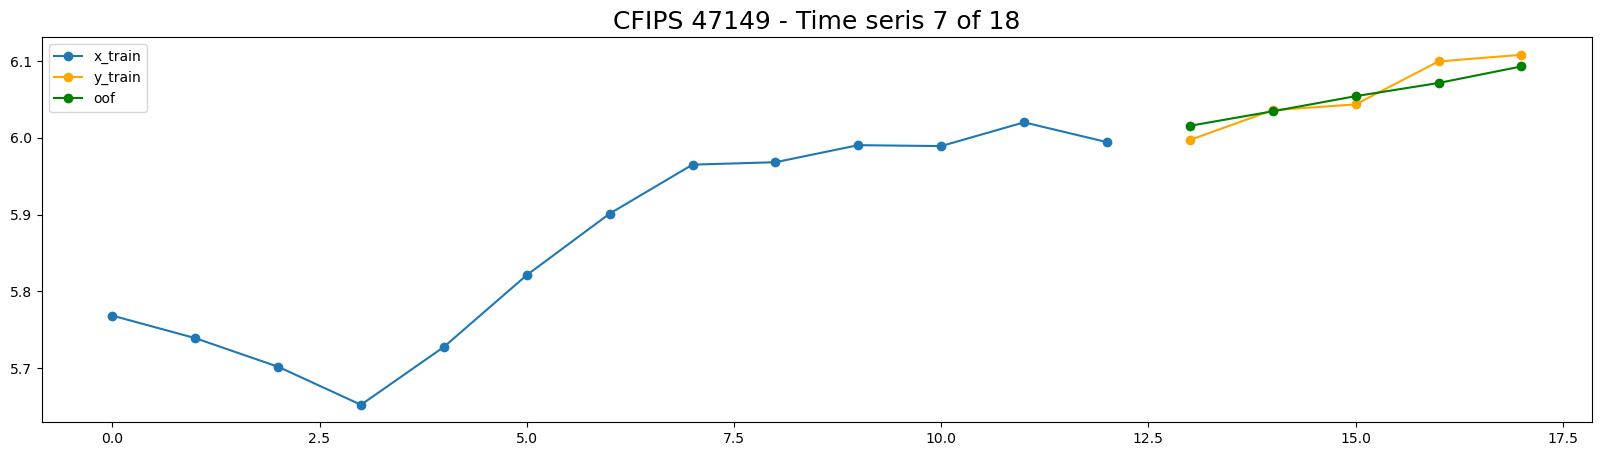

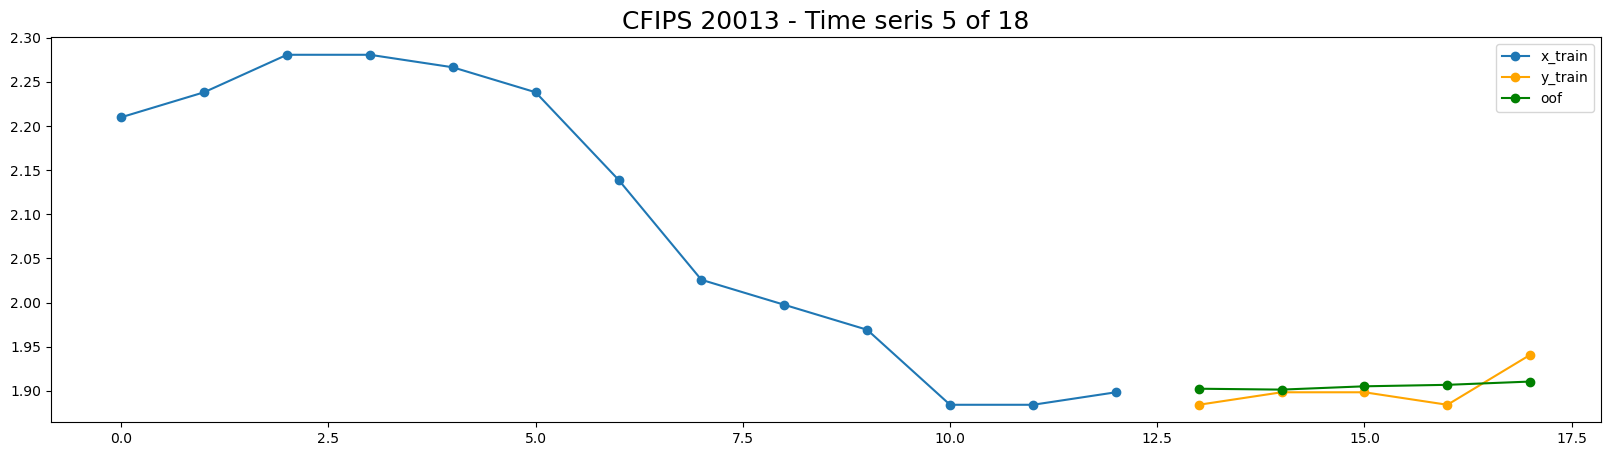

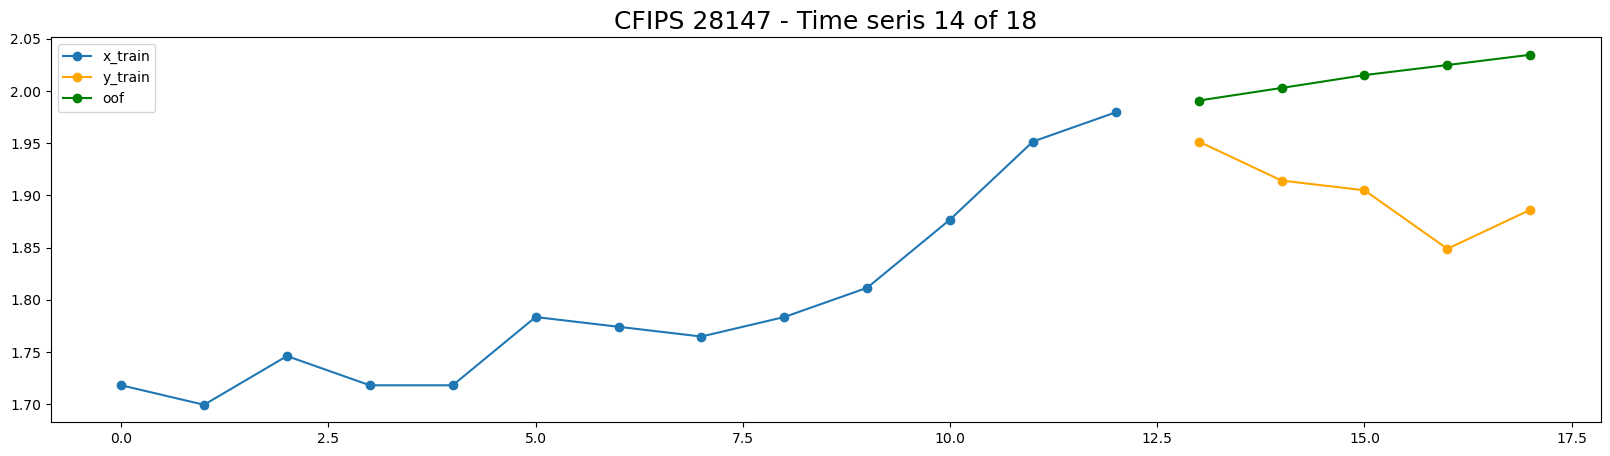

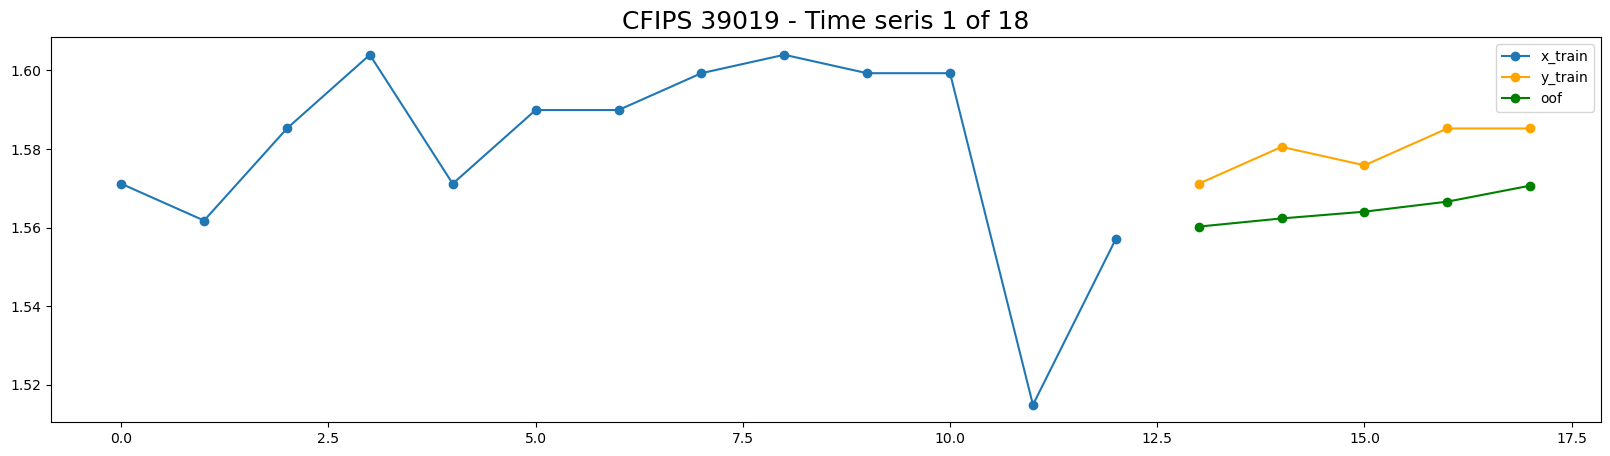

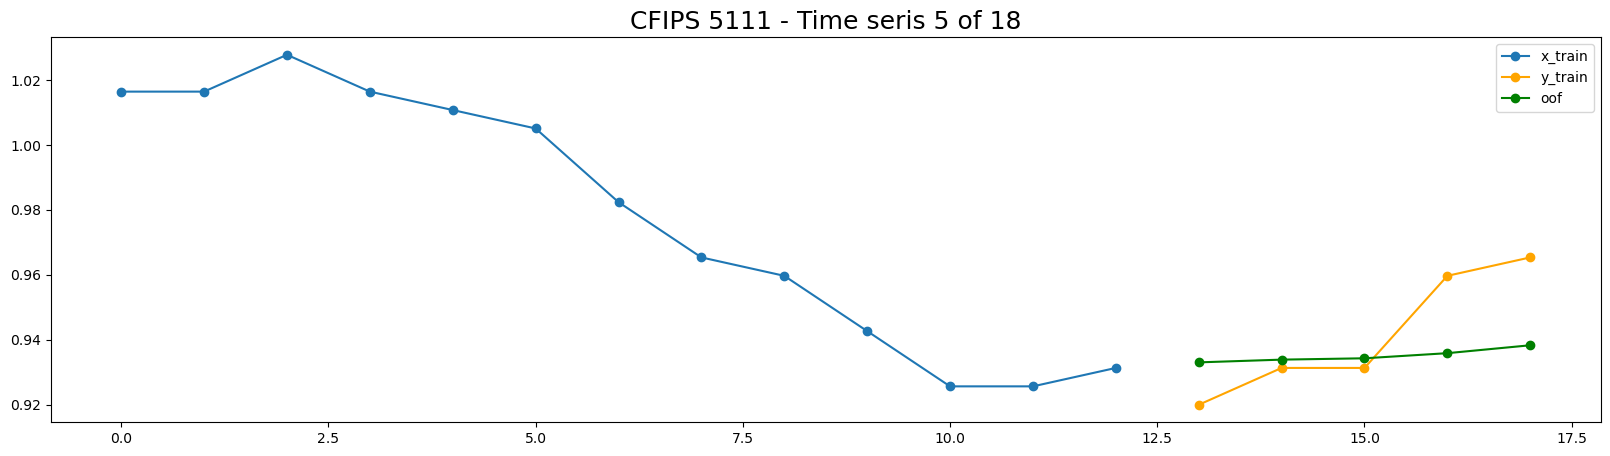

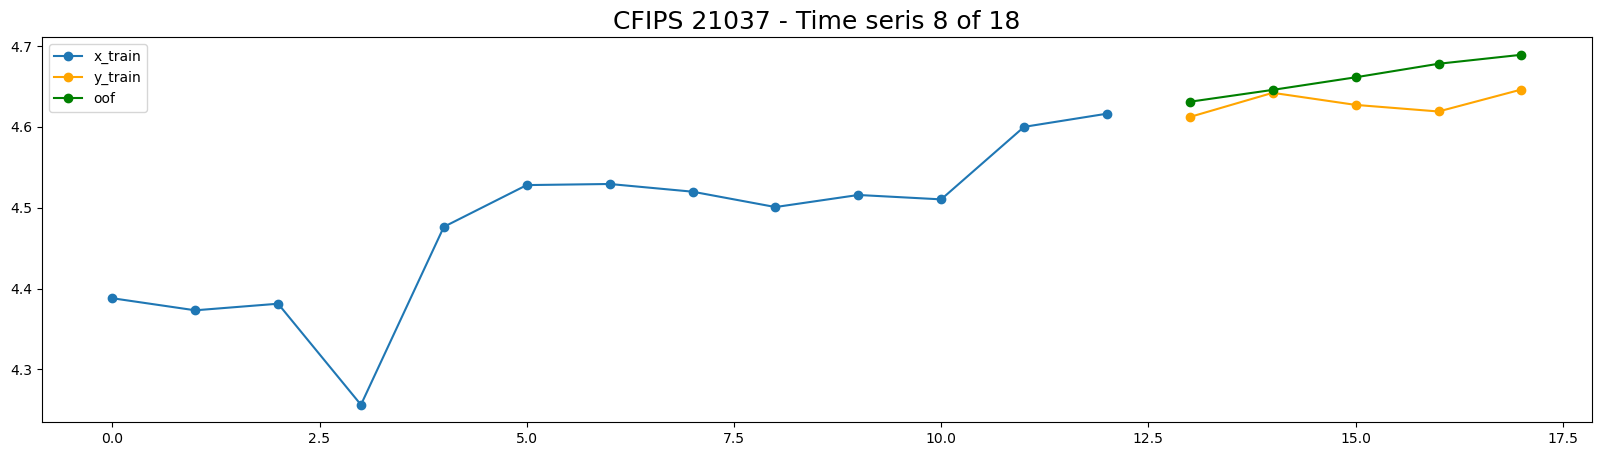

In [36]:
for k in range(8):
    j = np.random.choice(np.arange(len(x_data)))
    
    row = j//COPIES
    col = j%COPIES
    
    plt.figure(figsize=(20,5))
    x = np.arange(WIDTH-COPIES-4)
    plt.plot(x,x_data[j,],'-o',label='x_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES],y_data[j,],'-o',color='orange',label='y_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES], oof5[j,],'-o',color='green',label='oof')  
    plt.title(f'CFIPS {KEEP[row]} - Time seris {col} of {COPIES}',size=18)
    plt.legend()
    plt.show()

In [37]:
# PREPARE TEST DATA
LL = WIDTH-COPIES-4
test0 = data[:,-1*LL:].copy()
test = data[:,-1*LL:].copy()

# CONVERT TO RATIO AND STANDARDIZE
for k in range(WIDTH-COPIES-5):
    test[:,k+1] = test0[:,k+1] / test0[:,k]
test = test[:,1:]
test = (test-mn)/sd
print('Test data shape:',test.shape)

Test data shape: (2814, 12)


In [38]:
pred = np.zeros((len(test),5))

for fold in range(FOLDS):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    model = build_model()
    model.load_weights(f'models/GRU_f{fold}_v{VER}.h5')

    pred += model.predict(test, verbose=VERBOSE) / FOLDS

#########################
### Fold 1
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 2
#########################
88/88 - 2s - 2s/epoch - 19ms/step
#########################
### Fold 3
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 4
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 5
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 6
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 7
#########################
88/88 - 2s - 2s/epoch - 19ms/step
#########################
### Fold 8
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 9
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
### Fold 10
#########################
88/88 - 2s - 2s/epoch - 18ms/step
#########################
###

In [39]:
# UNDO STANDARDIZATION
pred2 = pred.copy()
pred2 = (pred2*sd)+mn
print('Prediction shape',pred2.shape)

Prediction shape (2814, 5)


In [40]:
# AVERAGE PREDICTED RATIO FOR 5 FUTURE MONTHS
for k in range(5):
    print(pred2[:,k].mean(), f' is average predicted future month {k+1} divided by future month {k}')

1.003390151704885  is average predicted future month 1 divided by future month 0
1.0030300230157108  is average predicted future month 2 divided by future month 1
1.0034688222211785  is average predicted future month 3 divided by future month 2
1.0033890123698754  is average predicted future month 4 divided by future month 3
1.0033174887533527  is average predicted future month 5 divided by future month 4


In [41]:
# CONVERT RATIOS INTO MICROBUSINESS DENSITY
pred5 = pred2.copy()
pred5[:,0] = test0[:,-1] * pred5[:,0]
for k in range(4):
    pred5[:,k+1] = pred5[:,k] * pred5[:,k+1]

In [42]:
# LOAD LAST VALUE BASELINE
# https://www.kaggle.com/code/cdeotte/new-last-value-baseline-1-4631
final_pred = pd.read_csv('/kaggle/input/new-last-value-baseline-1-4631/submission.csv')
final_pred['date'] = final_pred.row_id.apply(lambda x: x.split('_')[1])
final_pred['cfips'] = final_pred.row_id.apply(lambda x: int(x.split('_')[0]))
final_pred = final_pred.sort_values(['cfips','date'])
print( final_pred.shape )
final_pred.head()

(25080, 4)


,row_id,microbusiness_density,date,cfips
0,1001_2022-11-01,3.319231,2022-11-01,1001
3135,1001_2022-12-01,3.319231,2022-12-01,1001
6270,1001_2023-01-01,3.319231,2023-01-01,1001
9405,1001_2023-02-01,3.319231,2023-02-01,1001
12540,1001_2023-03-01,3.319231,2023-03-01,1001


In [43]:
MONS = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01']
for k in range(5):
    final_pred.loc[(final_pred['date']==MONS[k])&(final_pred.cfips.isin(KEEP)),'microbusiness_density'] = pred5[:,k]
final_pred = final_pred.reset_index(drop=True)
final_pred.head(16)

,row_id,microbusiness_density,date,cfips
0,1001_2022-11-01,3.319231,2022-11-01,1001
1,1001_2022-12-01,3.319231,2022-12-01,1001
2,1001_2023-01-01,3.331119,2023-01-01,1001
3,1001_2023-02-01,3.341881,2023-02-01,1001
4,1001_2023-03-01,3.354074,2023-03-01,1001
5,1001_2023-04-01,3.365742,2023-04-01,1001
6,1001_2023-05-01,3.377116,2023-05-01,1001
7,1001_2023-06-01,3.319231,2023-06-01,1001
8,1003_2022-11-01,7.935207,2022-11-01,1003
9,1003_2022-12-01,7.935207,2022-12-01,1003
